C:\Users\Charl\anaconda3\envs\ERA5\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


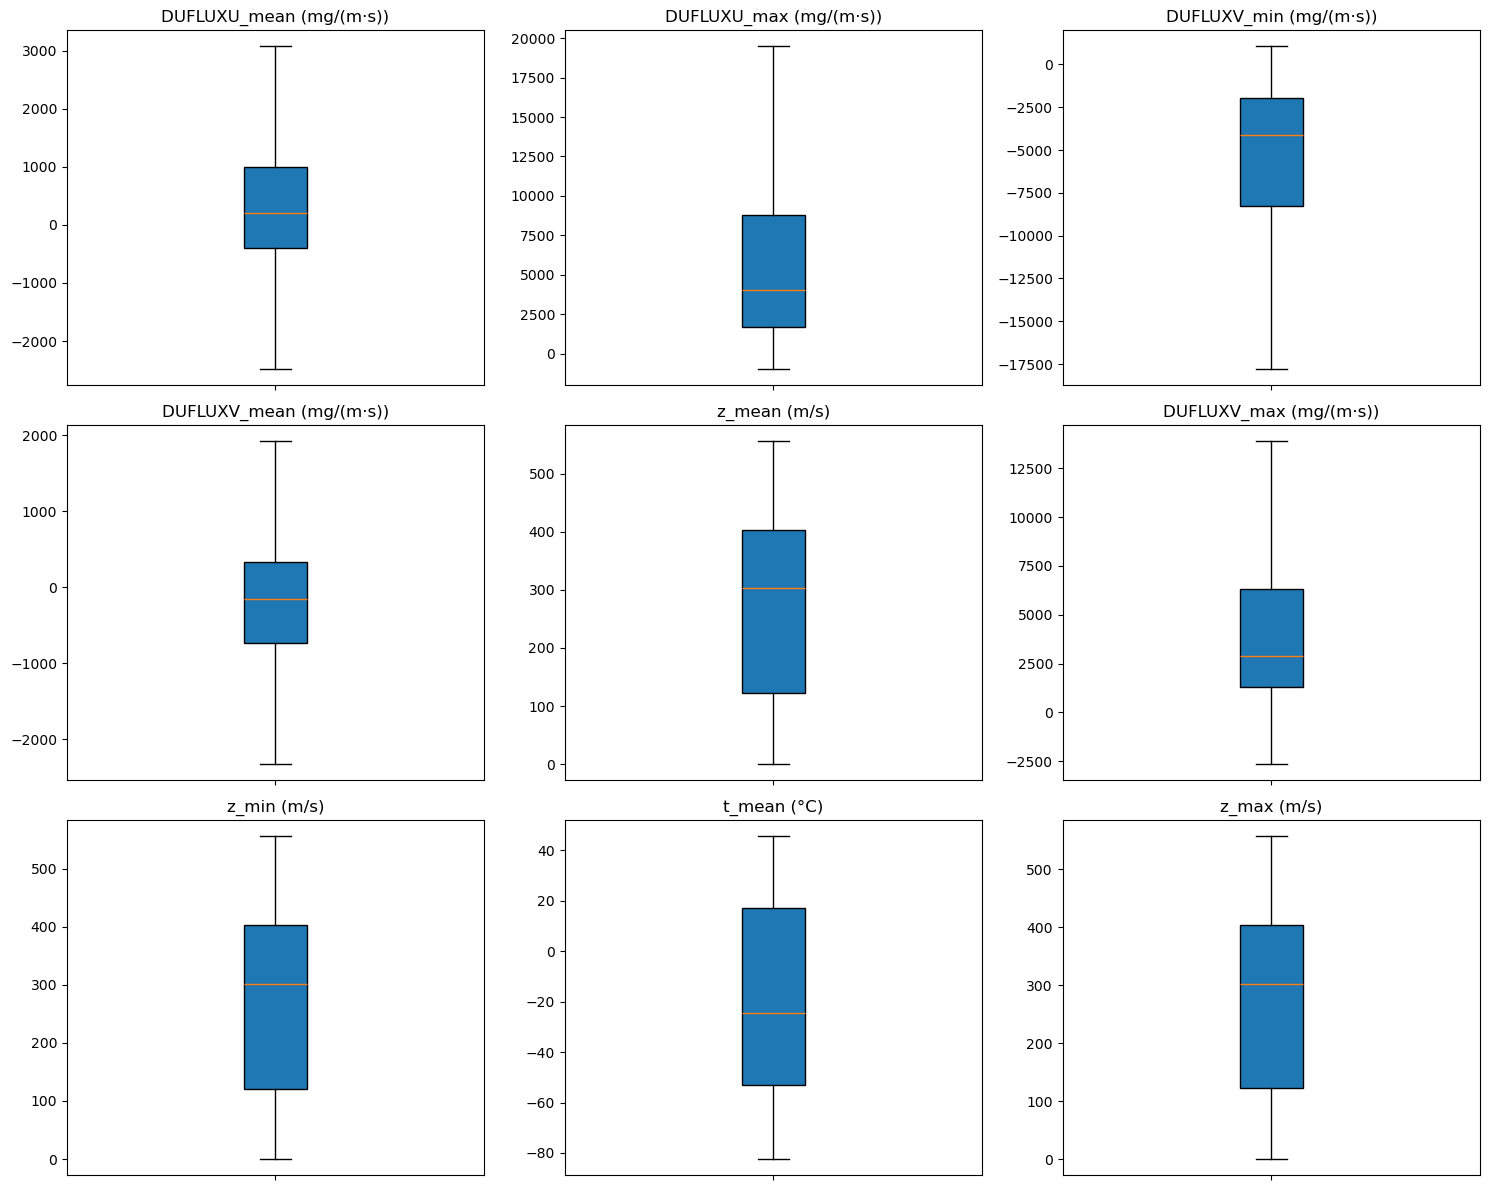

Summary statistics saved to Z:\Thesis\Data\test\DustCast\UA\DC_v0063\boxplots\top10_feat\summary_statistics.csv


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_training2"
output_dir = r"Z:\Thesis\Data\test\DustCast\UA\DC_v0063\boxplots\top10_feat"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# In the original file the columns include suffixes like _min, _max, _mean.
# Here is the list of variables we want to process:
desired_vars = [
    "DUFLUXU_mean", "lag_1", "DUFLUXU_max", "DUFLUXV_min", "DUFLUXV_mean", 
    "z_mean", "DUFLUXV_max", "z_min", "t_mean", "z_max"
]

# ------------------------- DATA LOADING & COMBINING -------------------------
# The original data loading step uses a set of selected columns. In this case,
# we load all the variables present in the file.
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_pressure_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

# Combine all dataframes into one
df_all = pd.concat(all_dfs, ignore_index=True)

# Ensure all columns are numeric where applicable
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- SELECT DESIRED VARIABLES -------------------------
# Because the desired variable names may have different letter cases or suffixes,
# define a helper function to check for a column's existence.
def get_existing_col(df, colname):
    # First, try the name as given.
    if colname in df.columns:
        return colname
    # Next, try an uppercase version.
    alt = colname.upper()
    if alt in df.columns:
        return alt
    # Finally, try a lowercase version.
    alt = colname.lower()
    if alt in df.columns:
        return alt
    return None

# Build a list of columns to keep.
existing_vars = []
for var in desired_vars:
    col = get_existing_col(df_all, var)
    if col is not None:
        existing_vars.append(col)
    else:
        print(f"Warning: Variable '{var}' not found in the data.")

# If none of the desired variables are found, exit.
if not existing_vars:
    raise ValueError("None of the desired variables were found in the data.")

# Filter the DataFrame to only the existing desired variables.
df_selected = df_all[existing_vars].copy()

# ------------------------- UNIT CONVERSIONS -------------------------
# Apply conversions only if the variable is present.
if get_existing_col(df_selected, "t_mean") is not None:
    df_selected[get_existing_col(df_selected, "t_mean")] = df_selected[get_existing_col(df_selected, "t_mean")] - 273.15

if get_existing_col(df_selected, "msl_mean") is not None:
    df_selected[get_existing_col(df_selected, "msl_mean")] = df_selected[get_existing_col(df_selected, "msl_mean")] / 100

# For dust flux variables, convert from kg/(m·s) to mg/(m·s) by multiplying by 1e6.
dust_flux_cols = ["DUFLUXV_min", "DUFLUXV_mean", "DUFLUXU_max", "DUFLUXU_mean", "DUFLUXV_max"]
for col in dust_flux_cols:
    existing = get_existing_col(df_selected, col)
    if existing is not None:
        df_selected[existing] = df_selected[existing] * 1e6

# For z variables (z_mean, z_min, z_max), convert from m²/s² to m/s by taking the square root.
for z_col in ["z_mean", "z_min", "z_max"]:
    existing = get_existing_col(df_selected, z_col)
    if existing is not None:
        df_selected[existing] = np.sqrt(df_selected[existing])


# ------------------------- CREATE SERIES & DEFINE UNITS -------------------------
# Create a dictionary of series for each variable (dropping NaN values)
variable_series = {}
for var in desired_vars:
    col = get_existing_col(df_selected, var)
    if col is not None:
        variable_series[var] = df_selected[col].dropna()

# Define the unit labels for each variable.
# (Use the desired variable names as keys.)
variable_units = {
    "DUFLUXU_mean": "mg/(m·s)",
    "DUFLUXU_max": "mg/(m·s)",
    "DUFLUXV_min": "mg/(m·s)",
    "DUFLUXV_mean": "mg/(m·s)",
    "z_mean": "m/s",       # updated unit after square root conversion
    "DUFLUXV_max": "mg/(m·s)",
    "z_min": "m/s",        # updated unit
    "t_mean": "°C",
    "z_max": "m/s",        # updated unit
}


# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3  # adjust number of columns in the facet layout as desired
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)  # flatten axes array

for i, (var, series) in enumerate(variable_series.items()):
    ax = axes[i]
    ax.boxplot(series, notch=False, patch_artist=True, showfliers=False)
    unit = variable_units.get(var, "")
    ax.set_title(f"{var} ({unit})")
    ax.set_xticklabels([])
    #ax.ticklabel_format(style='plain', axis='y', useOffset=False)


# Hide any unused subplots.
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
save_path = os.path.join(output_dir, "UA_top10_tree_feature_boxplots.png")
plt.savefig(save_path)
plt.show()
plt.close(fig)

# ------------------------- COMPUTE SUMMARY STATISTICS -------------------------
summary_data = []
for var, series in variable_series.items():
    count = series.count()
    min_val = series.min()
    percentile_25 = series.quantile(0.25)
    median = series.median()
    percentile_75 = series.quantile(0.75)
    mean = series.mean()
    max_val = series.max()
    std = series.std()
    variability_range = max_val - min_val  # Variability Range = Max - Min

    summary_data.append({
        "Variable": var,
        "Count": count,
        "Min": min_val,
        "25th Percentile": percentile_25,
        "Median": median,
        "75th Percentile": percentile_75,
        "Mean": mean,
        "Max": max_val,
        "Std": std,
        "Variability Range": variability_range
    })

# Create a DataFrame for the summary statistics
df_summary = pd.DataFrame(summary_data)

# Save the summary statistics to a CSV file in the output directory
csv_output_path = os.path.join(output_dir, "summary_statistics.csv")
df_summary.to_csv(csv_output_path, index=False)

print(f"Summary statistics saved to {csv_output_path}")
